In [78]:
import pandas as pd

# 读取并解析
df = pd.read_csv("prediction_results_fs.txt", sep=",", header=None, names=["AOI_ID", "Label"])
df["CID"] = df["AOI_ID"].apply(lambda x: int(x.lower().replace("aoi_", "").replace(".png", "")) + 1)

# 按 CID 排序
df = df.sort_values(by="CID").reset_index(drop=True)

# 查看排序后的结果
df

# 可选保存
# df.to_csv("prediction_results_sorted.csv", index=False)


,AOI_ID,Label,CID
0,aoi_1.png,0,2
1,aoi_2.png,0,3
2,aoi_3.png,1,4
3,aoi_4.png,0,5
4,aoi_5.png,0,6
...,...,...,...
3999,aoi_4699.png,0,4700
4000,aoi_4700.png,0,4701
4001,aoi_4701.png,1,4702
4002,aoi_4703.png,1,4704


In [100]:
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import shape
from geopandas import GeoDataFrame

# === Step 1: 读取预测结果，提取 AOI 编号 ===
df = pd.read_csv("prediction_results_zs.txt", sep=",", header=None, names=["AOI_ID", "Label"])
df["TARGET_FID"] = df["AOI_ID"].apply(lambda x: int(x.lower().replace("aoi_", "").replace(".png", "")))

# === Step 2: 手动读取 GeoJSON 避免 MultiPolygon 错误 ===
with open("中山市小区AOI2.geojson", "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

records = []
for feature in geojson_data["features"]:
    props = feature["properties"]
    try:
        props["geometry"] = shape(feature["geometry"])
        records.append(props)
    except Exception as e:
        print(f"⚠️ Geometry parsing failed: {e}")

gdf = GeoDataFrame(records, geometry="geometry")

# === Step 3: 合并标签（确保类型一致） ===
gdf["TARGET_FID"] = gdf["TARGET_FID"].astype(int)
df["Label"] = df["Label"].astype(int)
gdf = gdf.merge(df[["TARGET_FID", "Label"]], on="TARGET_FID", how="left")

# === Step 4: 处理 NaN 标签为 -1，确保字段完整 ===
gdf["Label"] = gdf["Label"].fillna(-1).astype(int)

# === Step 5: 设置原始投影为 WGS84，然后转换为 UTM 50N（EPSG:32650） ===
gdf = gdf[gdf.geometry.notnull() & ~gdf.geometry.is_empty]
gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=32650)

# === Step 6: 保存为新的 GeoJSON（适用于 QGIS 和后续分析） ===
output_path = "中山市小区AOI2_with_gated.geojson"
gdf.to_file(output_path, driver="GeoJSON", encoding="utf-8")

print(f"✅ 已成功保存：{output_path}，坐标系为 EPSG:32650")


✅ 已成功保存：中山市小区AOI2_with_gated.geojson，坐标系为 EPSG:32650


In [80]:
print(gdf.head())           # 检查字段是否有 geometry
print(gdf.geometry.is_empty.sum())   # 是否有为空几何
print(gdf.geometry.notnull().sum())  # 有效几何数量
print(gdf.crs)              # 是否保持投影


       name                       uid               address province city  \
0       华明楼  a4e2fce9f553b1c5c8e33ce5                彩泰巷17号      广东省  佛山市   
1      明海花园  9a7671e34a934e4f79b55c26               玉泉街道12号      广东省  佛山市   
2     绿地拾野川  dadcf548d0675d9082a12e4f  广东省佛山市高明区更合镇合和大道200号      广东省  佛山市   
3      雄毅豪苑  aff0e13d6e0a15c0c336441a     佛山市高明区更合镇更合大道771号      广东省  佛山市   
4  白石村碧玉轩小区  0f88bc481d91d7c0f1193745          高明区更合镇延丽路20号      广东省  佛山市   

  district  town        tags main_tag second_tag  ...  Shape_Leng  \
0      高明区  荷城街道  房地产,住宅区,小区      房地产        住宅区  ...    0.000486   
1      高明区  荷城街道     房地产,住宅区      房地产        住宅区  ...    0.002754   
2      高明区   更合镇     房地产,住宅区      房地产        住宅区  ...    0.006660   
3      高明区   更合镇  房地产,住宅区,小区      房地产        住宅区  ...    0.004897   
4      高明区   更合镇     房地产,住宅区      房地产        住宅区  ...    0.002313   

       Landarea  佛山市    Building_a        FAR  TARGET_FID  POI_Count  \
0    241.772410    0   4587.376299  18.973945     

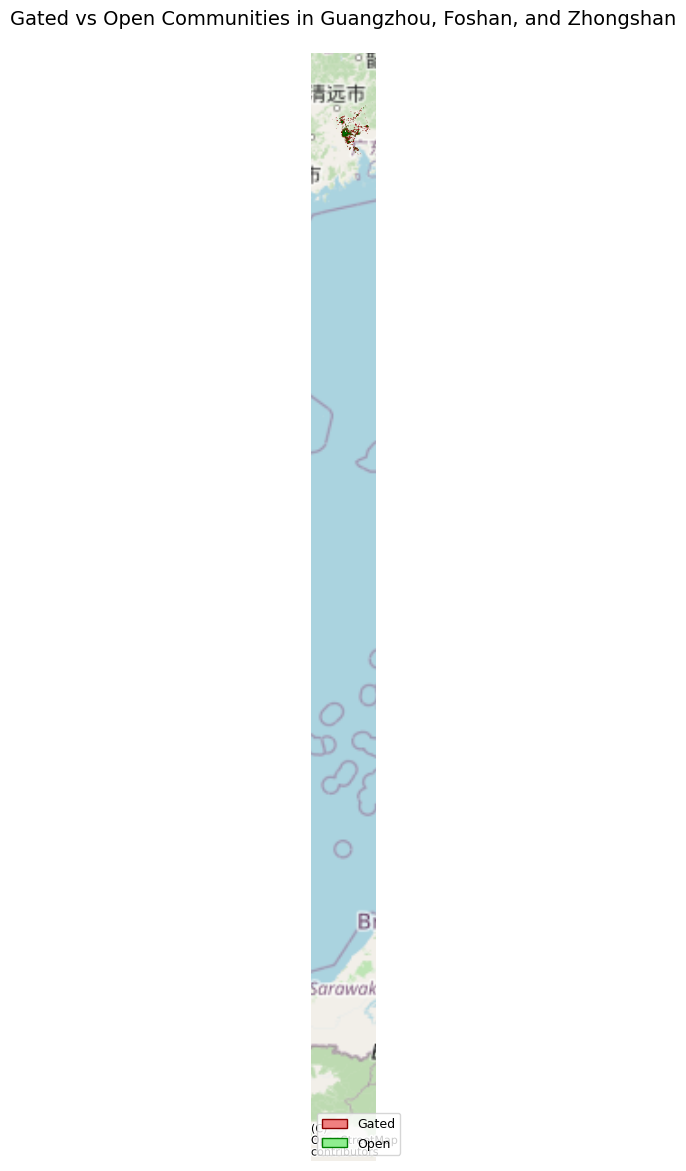

In [92]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.patches import Patch

# === 1. 读取数据并统一投影到 Web Mercator EPSG:3857 ===
gz = gpd.read_file("广州市小区AOI2_with_gated.geojson").to_crs(epsg=3857)
fs = gpd.read_file("佛山市小区AOI2_with_gated.geojson").to_crs(epsg=3857)
zs = gpd.read_file("中山市小区AOI2_with_gated.geojson").to_crs(epsg=3857)

# === 2. 创建图像 ===
fig, ax = plt.subplots(figsize=(12, 12))

# === 3. 分别绘制 gated 和 open（不直接用 label 参数）===
for gdf in [gz, fs, zs]:
    gdf[gdf["Label"] == 1].plot(ax=ax, color="lightcoral", edgecolor="darkred", linewidth=0.2)
    gdf[gdf["Label"] == 0].plot(ax=ax, color="lightgreen", edgecolor="green", linewidth=0.2)

# === 4. 添加底图 ===
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# === 5. 构建自定义图例 ===
legend_elements = [
    Patch(facecolor='lightcoral', edgecolor='darkred', label='Gated'),
    Patch(facecolor='lightgreen', edgecolor='green', label='Open')
]

ax.legend(handles=legend_elements, loc="lower left", fontsize=9)
ax.set_title("Gated vs Open Communities in Guangzhou, Foshan, and Zhongshan", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [89]:
import geopandas as gpd

gdf = gpd.read_file("佛山市小区AOI2_with_gated.geojson")

# 确保几何合法、字段类型统一
gdf = gdf[gdf.is_valid]
gdf["Label"] = gdf["Label"].fillna(-1).astype(int)

# 简化字段名以兼容 Shapefile
gdf = gdf.rename(columns=lambda x: x[:10])

# 设置 CRS 明确
gdf = gdf.to_crs("EPSG:32650")

# 保存为 QGIS 可读格式（根据需求选择）
gdf.to_file("佛山_clean.geojson", driver="GeoJSON", encoding="utf-8")
gdf.to_file("佛山_clean.shp", driver="ESRI Shapefile", encoding="gbk")

In [20]:
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import shape
from geopandas import GeoDataFrame

# === Step 1: 读取 prediction label 并提取 CID ===
df = pd.read_csv("prediction_results_zs.txt", sep=",", header=None, names=["AOI_ID", "Label"])
df["CID"] = df["AOI_ID"].apply(lambda x: int(x.lower().replace("aoi_", "").replace(".png", "")) + 1)

# === Step 2: 手动解析 GeoJSON，规避 MultiPolygon 错误 ===
with open("中山市小区AOI2.geojson", "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

records = []
for feature in geojson_data["features"]:
    props = feature["properties"]
    props["geometry"] = shape(feature["geometry"])
    records.append(props)

gdf = GeoDataFrame(records, geometry="geometry")

# === Step 3: 合并 CID 和 gated label ===
gdf["CID"] = gdf["CID"].astype(int)
df["Label"] = df["Label"].astype(int)
gdf = gdf.merge(df[["CID", "Label"]], on="CID", how="left")

# === Step 4: 可选保存为新 GeoJSON ===
# 设置投影为 EPSG:32650（UTM zone 50N）
gdf.set_crs("EPSG:32650", inplace=True)

# 保存为新 GeoJSON，保留原投影
gdf.to_file("中山市小区AOI2_with_gated.geojson", driver="GeoJSON", encoding="utf-8")



KeyError: 'CID'

In [8]:
gdf

,name,uid,address,province,city,district,town,tags,main_tag,second_tag,...,WGS84_lat,Shape_Leng,landarea,CID,Building_a,FAR,POI_Count,POI_Densit,geometry,Label
0,映翠苑,0dc3d82d20c6d91175e5b64f,广州市花都区赤坭镇碧桂园假日半岛,广东省,广州市,花都区,赤坭镇,"房地产,住宅区,小区",房地产,住宅区,...,23.484842,0.038412,420856.582371,1,9668.669013,0.022974,9,0.000021,"MULTIPOLYGON (((98265.443 2603048.934, 98335.4...",1.0
1,淘花园,edf81640790f5a2826d2bb27,广州市荔湾区倾伍二横街海中小学东北侧约230米,广东省,广州市,荔湾区,中南街道,"房地产,住宅区",房地产,住宅区,...,23.060562,0.001811,2852.160237,2,1740.214621,0.610139,3,0.001052,"MULTIPOLYGON (((110446.458 2555300.256, 110447...",0.0
2,花猫花园,b91e80ba21873985b320a8c3,广东省广州市荔湾区水仙路6号,广东省,广州市,荔湾区,海龙街道,"房地产,住宅区",房地产,住宅区,...,23.068856,0.001745,2743.812958,3,597.189829,0.217650,1,0.000364,"MULTIPOLYGON (((110498.872 2556244.638, 110538...",0.0
3,广州宏信悦谷,87e2dded55afa9cd9d95defb,广东省广州市荔湾区龙溪大道江北路3号,广东省,广州市,荔湾区,海龙街道,"房地产,住宅区",房地产,住宅区,...,23.073680,0.004590,15816.769294,4,0.000000,0.000000,2,0.000126,"MULTIPOLYGON (((110321.856 2556662.306, 110320...",0.0
4,越秀星汇金沙,ec686c10426152efb6147f45,广州市白云区汇锦街3号g9栋502房,广东省,广州市,白云区,金沙街道,"房地产,住宅区",房地产,住宅区,...,23.161401,0.028970,218772.900943,5,334736.075315,1.530062,93,0.000425,"MULTIPOLYGON (((109780.337 2566489.498, 109779...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8911,碧桂园东湖1号2期,d8cca3dd346744d695ca0716,广州市增城区东湖东路增城高级中学西侧约70米,广东省,广州市,增城区,增江街道,"房地产,住宅区",房地产,住宅区,...,23.291142,0.003302,9836.404606,8912,5672.678096,0.576702,17,0.001728,"MULTIPOLYGON (((177396.571 2579289.604, 177404...",1.0
8912,碧桂园东湖世家,1de77bb71a30be4626e0a064,广东省广州市增城区X196(东桥东路),广东省,广州市,增城区,增江街道,"房地产,住宅区,小区",房地产,住宅区,...,23.289921,0.003035,7894.880303,8913,2176.430962,0.275676,1,0.000127,"MULTIPOLYGON (((177332.886 2579180.198, 177391...",1.0
8913,雅居轩,cc788fde0be53b8a89fc06bb,广东省广州市增城区东桥东路92号,广东省,广州市,增城区,增江街道,"房地产,住宅区,小区",房地产,住宅区,...,23.284803,0.001386,1783.891555,8914,2275.833611,1.275769,7,0.003924,"MULTIPOLYGON (((177267.276 2578535.398, 177267...",0.0
8914,首创碧桂园悦山府,10dfe3c7a7f9e8159f09f7fa,狮尾路1号,广东省,广州市,增城区,增江街道,"房地产,住宅区",房地产,住宅区,...,23.284019,0.007712,33701.402248,8915,4299.226553,0.127568,12,0.000356,"MULTIPOLYGON (((177391.197 2578498.926, 177494...",1.0


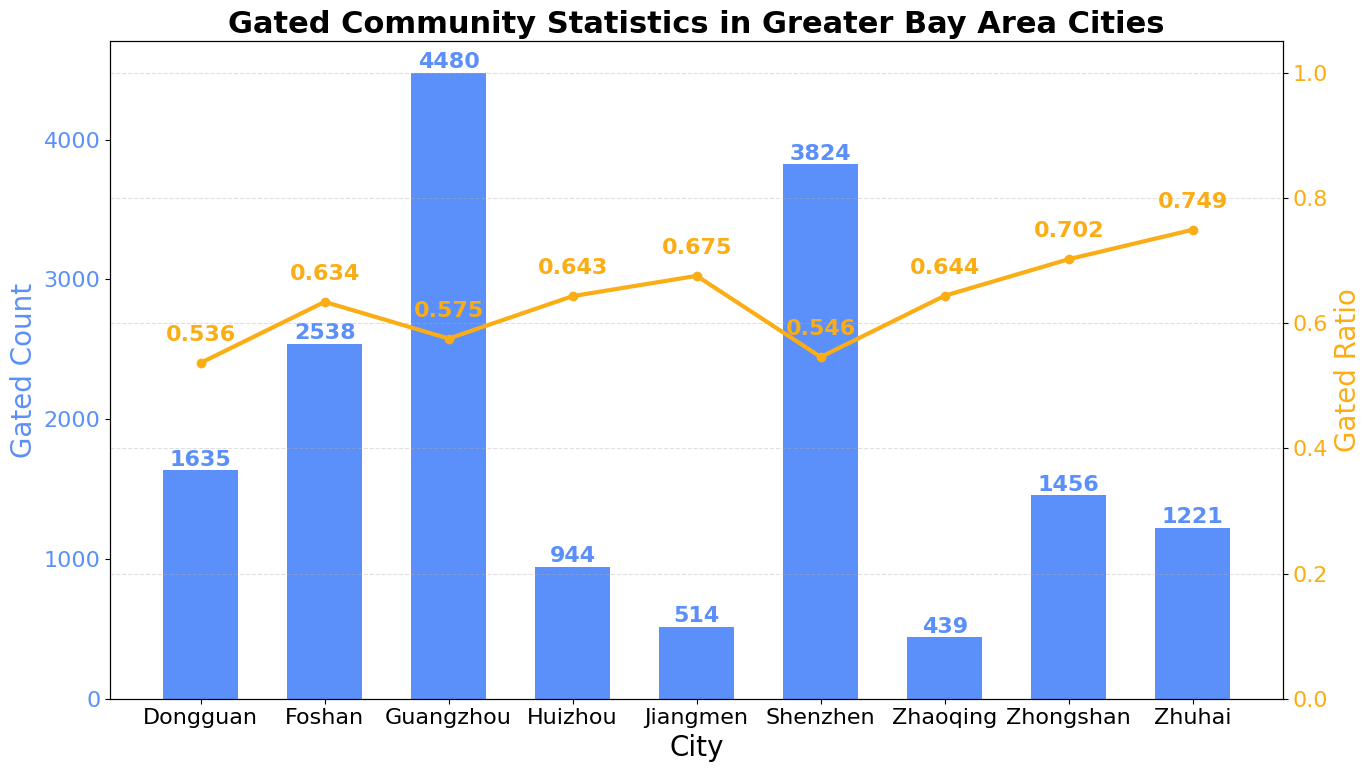


=== Gated Community Statistics ===
  City_EN  Gated Count  Total Count Gated Ratio
 Dongguan         1635         3048       0.536
   Foshan         2538         4004       0.634
Guangzhou         4480         7788       0.575
  Huizhou          944         1468       0.643
 Jiangmen          514          761       0.675
 Shenzhen         3824         7006       0.546
 Zhaoqing          439          682       0.644
Zhongshan         1456         2074       0.702
   Zhuhai         1221         1630       0.749


In [38]:
import os
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

# 设置全局字体更大、更清晰
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16
})

# 城市中英文映射
city_mapping = {
    "广州": "Guangzhou",
    "深圳": "Shenzhen",
    "佛山": "Foshan",
    "东莞": "Dongguan",
    "中山": "Zhongshan",
    "江门": "Jiangmen",
    "珠海": "Zhuhai",
    "肇庆": "Zhaoqing",
    "惠州": "Huizhou"
}
cities = list(city_mapping.keys())
filename_template = "{}市小区AOI2_with_gated.geojson"
data_dir = "./"  # 修改为你的实际路径

stats = []

# 遍历每个城市
for city_cn in cities:
    file_path = os.path.join(data_dir, filename_template.format(city_cn))
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        continue

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            geojson_data = json.load(f)

        records = []
        for feat in geojson_data["features"]:
            props = feat["properties"]
            try:
                props["geometry"] = shape(feat["geometry"])
                records.append(props)
            except Exception as e:
                print(f"⚠️ Geometry error in {city_cn}, skipped one feature: {e}")

        gdf = GeoDataFrame(records, geometry="geometry")
        gdf = gdf[gdf["Label"].isin([0, 1])]

        total = len(gdf)
        gated = (gdf["Label"] == 1).sum()
        ratio = gated / total if total > 0 else 0

        stats.append({
            "City_EN": city_mapping[city_cn],
            "Gated Count": gated,
            "Total Count": total,
            "Gated Ratio": ratio
        })

    except Exception as e:
        print(f"❌ Failed to process {city_cn}: {e}")

# 绘图
if len(stats) == 0:
    print("❌ No data available.")
else:
    df = pd.DataFrame(stats).sort_values("City_EN")

    fig, ax1 = plt.subplots(figsize=(14, 8))

    cities = df["City_EN"]
    gated_counts = df["Gated Count"]
    gated_ratios = df["Gated Ratio"]

    # 柱状图（蓝紫色）
    bars = ax1.bar(cities, gated_counts, color="#5B8FF9", width=0.6)
    ax1.set_ylabel("Gated Count", color="#5B8FF9", fontsize=20)
    ax1.set_xlabel("City", fontsize=20)
    ax1.tick_params(axis='y', labelcolor="#5B8FF9")

    # 柱子顶部标签
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 5, f'{int(height)}',
                 ha='center', va='bottom', fontsize=16, weight='bold', color="#5B8FF9")

    # 折线图（亮橙色）
    ax2 = ax1.twinx()
    ax2.plot(cities, gated_ratios, color="#FAAD14", marker='o', linewidth=3)
    ax2.set_ylabel("Gated Ratio", color="#FAAD14", fontsize=20)
    ax2.tick_params(axis='y', labelcolor="#FAAD14")
    ax2.set_ylim(0, 1.05)

    # 比例点上方标签（保留3位小数）
    for i, ratio in enumerate(gated_ratios):
        ax2.text(i, ratio + 0.035, f"{ratio:.3f}", ha='center',
                 fontsize=16, weight='bold', color="#FAAD14")

    # 主标题
    plt.title("Gated Community Statistics in Greater Bay Area Cities", fontsize=22, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    # 自动布局 + 保存 + 展示
    fig.tight_layout()
    fig.savefig("gated_community_stats.png", dpi=600, bbox_inches='tight')
    plt.show()

    # 表格打印
    print("\n=== Gated Community Statistics ===")
    print(df.to_string(index=False, formatters={"Gated Ratio": lambda x: f"{x:.3f}"}))


C:\Users\admin\AppData\Local\Temp\ipykernel_34664\2417670275.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gated_union = gated_clip.unary_union  # 所有 gated 的 union（MultiPolygon）
C:\Users\admin\AppData\Local\Temp\ipykernel_34664\2417670275.py:125: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower left", fontsize=9)


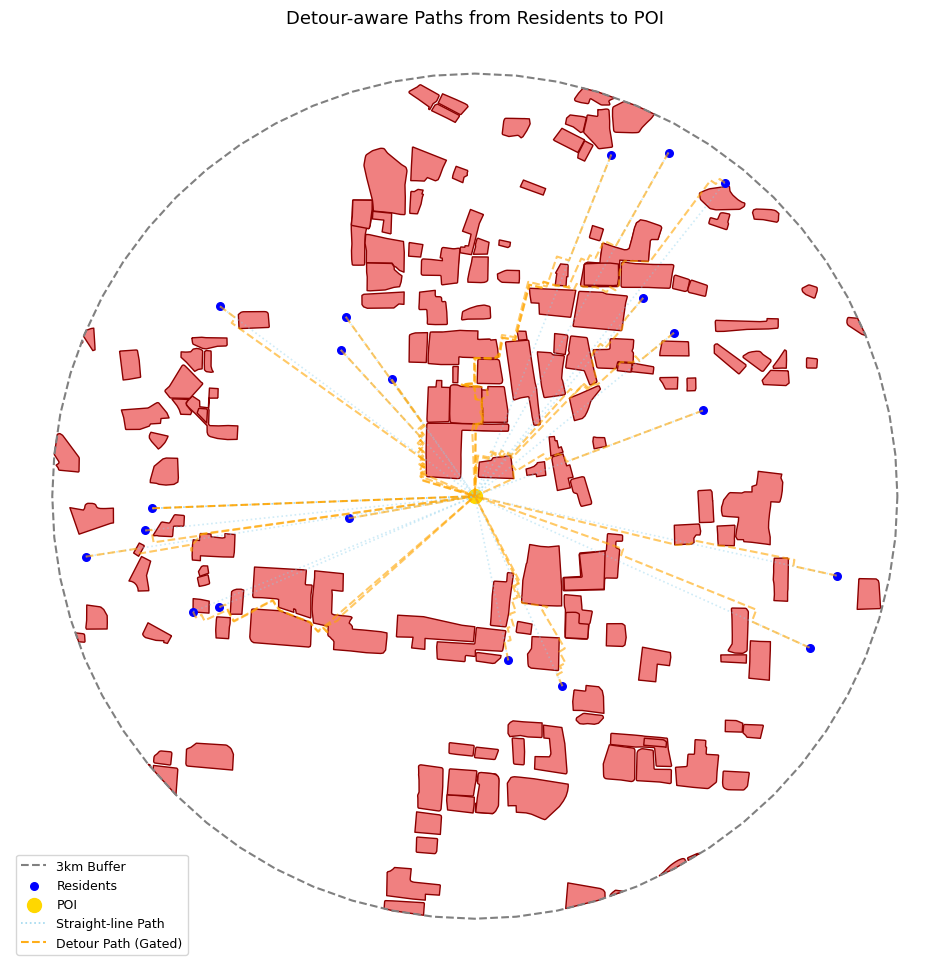

✅ Average Detour Index: 1.164
✅ Max Detour Index: 1.477
✅ Extra Distance (avg, m): 225.07
✅ Blocked Ratio (>1.05): 70.0 %


In [73]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

# === 1. 读取数据 ===
poi = gpd.read_file("太古汇.geojson").to_crs("EPSG:32650")
gated = gpd.read_file("广州gatedcom.geojson").to_crs("EPSG:32650")

poi_buffer = poi.buffer(2000)
buffer_gdf = gpd.GeoDataFrame(geometry=poi_buffer, crs="EPSG:32650")
gated_clip = gpd.overlay(gated, buffer_gdf, how="intersection")

# === 2. 创建居民点 ===
# === 2. 创建居民点（不落入 gated） ===
from shapely.geometry import MultiPolygon

gated_union = gated_clip.unary_union  # 所有 gated 的 union（MultiPolygon）
valid_points = []
while len(valid_points) < 20:
    x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
    pt = Point(x, y)
    if buffer_gdf.contains(pt).any() and not gated_union.contains(pt):
        valid_points.append(pt)

residents = gpd.GeoDataFrame(geometry=valid_points, crs="EPSG:32650")


# === 3. 新路径算法：多次连续避障 ===
def smart_detour_path(start, goal, obstacles, step=30, max_steps=4000):
    path = [start]
    current = start
    stuck_counter = 0
    for _ in range(max_steps):
        direction = np.array([goal.x - current.x, goal.y - current.y])
        distance = np.linalg.norm(direction)
        if distance < step:
            path.append(goal)
            break

        direction = direction / distance
        next_pt = Point(current.x + direction[0]*step, current.y + direction[1]*step)

        if any(poly.contains(next_pt) for poly in obstacles):
            found = False
            for angle in np.linspace(-180, 180, 90):  # 尝试更多角度（每 5°）
                theta = np.radians(angle)
                rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
                new_dir = rot @ direction
                candidate = Point(current.x + new_dir[0]*step, current.y + new_dir[1]*step)

                # 条件：不能进障碍物，且向目标靠近
                if not any(poly.contains(candidate) for poly in obstacles) and candidate.distance(goal) < current.distance(goal):
                    current = candidate
                    path.append(current)
                    found = True
                    stuck_counter = 0  # 重置卡死计数器
                    break

            if not found:
                # 尝试「微扰」跳出卡死区域（模拟走人缝）
                stuck_counter += 1
                if stuck_counter >= 30:
                    direction = direction + np.random.normal(0, 0.2, 2)
                    direction = direction / np.linalg.norm(direction)
                    current = Point(current.x + direction[0]*step, current.y + direction[1]*step)
                    path.append(current)
                    stuck_counter = 0
        else:
            current = next_pt
            path.append(current)

    if len(path) < 1:
        return LineString([start, goal])  # fallback
    return LineString(path)



# === 4. 路径计算 ===
target = poi.geometry.iloc[0]
paths_detour, paths_direct, detour_indices = [], [], []

for p in residents.geometry:
    direct = LineString([p, target])
    paths_direct.append(direct)

    intersects = any(poly.intersects(direct) for poly in gated_clip.geometry)
    if not intersects:
        detour_path = direct
        detour_index = 1.0
    else:
        detour_path = smart_detour_path(p, target, gated_clip.geometry)
        detour_index = detour_path.length / p.distance(target)

    paths_detour.append(detour_path)
    detour_indices.append(detour_index)

residents["detour_index"] = detour_indices

# === 5. 绘图 ===
fig, ax = plt.subplots(figsize=(10, 10))
buffer_gdf.boundary.plot(ax=ax, color="gray", linestyle="--", label="3km Buffer")
gated_clip.plot(ax=ax, color="lightcoral", edgecolor="darkred", label="Gated Communities")
residents.plot(ax=ax, color="blue", markersize=30, label="Residents")
poi.plot(ax=ax, color="gold", markersize=100, label="POI")

# 避障与直线
drawn = {"direct": False, "detour": False}
for direct, detour in zip(paths_direct, paths_detour):
    if not drawn["direct"]:
        ax.plot(*direct.xy, color="skyblue", linestyle=":", linewidth=1.2, alpha=0.8, label="Straight-line Path")
        drawn["direct"] = True
    else:
        ax.plot(*direct.xy, color="skyblue", linestyle=":", linewidth=1.2, alpha=0.4)

    if not drawn["detour"]:
        ax.plot(*detour.xy, color="orange", linestyle="--", linewidth=1.5, alpha=0.9, label="Detour Path (Gated)")
        drawn["detour"] = True
    else:
        ax.plot(*detour.xy, color="orange", linestyle="--", linewidth=1.5, alpha=0.6)

plt.title("Detour-aware Paths from Residents to POI", fontsize=13)
plt.axis("off")
ax.legend(loc="lower left", fontsize=9)
plt.tight_layout()

# 保存为高分辨率 PNG 图像
plt.savefig("detour_paths_太古汇.png", dpi=600, bbox_inches="tight")

plt.show()

# === 6. 指标输出 ===
print("✅ Average Detour Index:", round(np.mean(detour_indices), 3))
print("✅ Max Detour Index:", round(np.max(detour_indices), 3))
print("✅ Extra Distance (avg, m):", round(np.mean([d.length - s.length for d, s in zip(paths_detour, paths_direct)]), 2))
print("✅ Blocked Ratio (>1.05):", round(np.mean(np.array(detour_indices) > 1.05)*100, 1), "%")

C:\Users\admin\AppData\Local\Temp\ipykernel_34664\650727969.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gated_union = gated_clip.unary_union  # 所有 gated 的 union（MultiPolygon）
C:\Users\admin\AppData\Local\Temp\ipykernel_34664\650727969.py:125: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower left", fontsize=9)


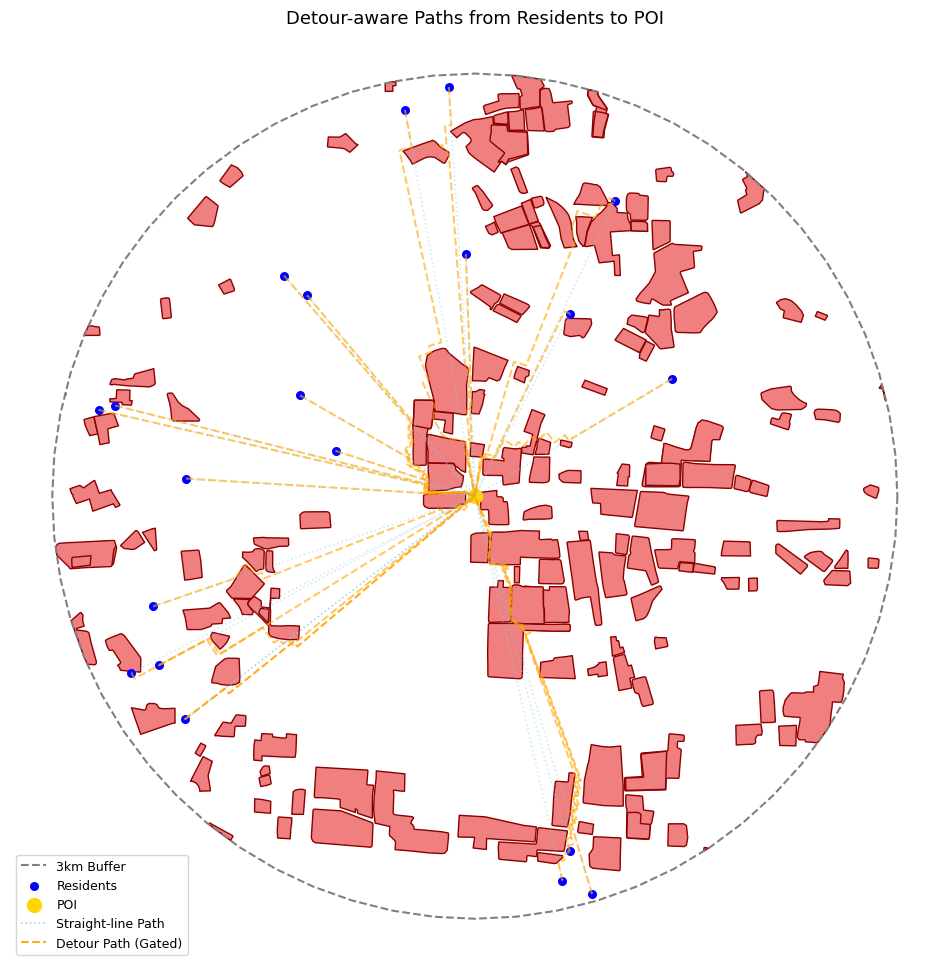

✅ Average Detour Index: 1.102
✅ Max Detour Index: 1.239
✅ Extra Distance (avg, m): 149.93
✅ Blocked Ratio (>1.05): 75.0 %


In [72]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

# === 1. 读取数据 ===
poi = gpd.read_file("天河妇幼保健院POI.geojson").to_crs("EPSG:32650")
gated = gpd.read_file("广州gatedcom.geojson").to_crs("EPSG:32650")

poi_buffer = poi.buffer(2000)
buffer_gdf = gpd.GeoDataFrame(geometry=poi_buffer, crs="EPSG:32650")
gated_clip = gpd.overlay(gated, buffer_gdf, how="intersection")

# === 2. 创建居民点 ===
# === 2. 创建居民点（不落入 gated） ===
from shapely.geometry import MultiPolygon

gated_union = gated_clip.unary_union  # 所有 gated 的 union（MultiPolygon）
valid_points = []
while len(valid_points) < 20:
    x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
    pt = Point(x, y)
    if buffer_gdf.contains(pt).any() and not gated_union.contains(pt):
        valid_points.append(pt)

residents = gpd.GeoDataFrame(geometry=valid_points, crs="EPSG:32650")


# === 3. 新路径算法：多次连续避障 ===
def smart_detour_path(start, goal, obstacles, step=30, max_steps=4000):
    path = [start]
    current = start
    stuck_counter = 0
    for _ in range(max_steps):
        direction = np.array([goal.x - current.x, goal.y - current.y])
        distance = np.linalg.norm(direction)
        if distance < step:
            path.append(goal)
            break

        direction = direction / distance
        next_pt = Point(current.x + direction[0]*step, current.y + direction[1]*step)

        if any(poly.contains(next_pt) for poly in obstacles):
            found = False
            for angle in np.linspace(-180, 180, 90):  # 尝试更多角度（每 5°）
                theta = np.radians(angle)
                rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
                new_dir = rot @ direction
                candidate = Point(current.x + new_dir[0]*step, current.y + new_dir[1]*step)

                # 条件：不能进障碍物，且向目标靠近
                if not any(poly.contains(candidate) for poly in obstacles) and candidate.distance(goal) < current.distance(goal):
                    current = candidate
                    path.append(current)
                    found = True
                    stuck_counter = 0  # 重置卡死计数器
                    break

            if not found:
                # 尝试「微扰」跳出卡死区域（模拟走人缝）
                stuck_counter += 1
                if stuck_counter >= 30:
                    direction = direction + np.random.normal(0, 0.2, 2)
                    direction = direction / np.linalg.norm(direction)
                    current = Point(current.x + direction[0]*step, current.y + direction[1]*step)
                    path.append(current)
                    stuck_counter = 0
        else:
            current = next_pt
            path.append(current)

    if len(path) < 1:
        return LineString([start, goal])  # fallback
    return LineString(path)



# === 4. 路径计算 ===
target = poi.geometry.iloc[0]
paths_detour, paths_direct, detour_indices = [], [], []

for p in residents.geometry:
    direct = LineString([p, target])
    paths_direct.append(direct)

    intersects = any(poly.intersects(direct) for poly in gated_clip.geometry)
    if not intersects:
        detour_path = direct
        detour_index = 1.0
    else:
        detour_path = smart_detour_path(p, target, gated_clip.geometry)
        detour_index = detour_path.length / p.distance(target)

    paths_detour.append(detour_path)
    detour_indices.append(detour_index)

residents["detour_index"] = detour_indices

# === 5. 绘图 ===
fig, ax = plt.subplots(figsize=(10, 10))
buffer_gdf.boundary.plot(ax=ax, color="gray", linestyle="--", label="3km Buffer")
gated_clip.plot(ax=ax, color="lightcoral", edgecolor="darkred", label="Gated Communities")
residents.plot(ax=ax, color="blue", markersize=30, label="Residents")
poi.plot(ax=ax, color="gold", markersize=100, label="POI")

# 避障与直线
drawn = {"direct": False, "detour": False}
for direct, detour in zip(paths_direct, paths_detour):
    if not drawn["direct"]:
        ax.plot(*direct.xy, color="skyblue", linestyle=":", linewidth=1.2, alpha=0.8, label="Straight-line Path")
        drawn["direct"] = True
    else:
        ax.plot(*direct.xy, color="skyblue", linestyle=":", linewidth=1.2, alpha=0.4)

    if not drawn["detour"]:
        ax.plot(*detour.xy, color="orange", linestyle="--", linewidth=1.5, alpha=0.9, label="Detour Path (Gated)")
        drawn["detour"] = True
    else:
        ax.plot(*detour.xy, color="orange", linestyle="--", linewidth=1.5, alpha=0.6)

plt.title("Detour-aware Paths from Residents to POI", fontsize=13)
plt.axis("off")
ax.legend(loc="lower left", fontsize=9)
plt.tight_layout()

# 保存为高分辨率 PNG 图像
plt.savefig("detour_paths_妇幼院.png", dpi=600, bbox_inches="tight")

plt.show()

# === 6. 指标输出 ===
print("✅ Average Detour Index:", round(np.mean(detour_indices), 3))
print("✅ Max Detour Index:", round(np.max(detour_indices), 3))
print("✅ Extra Distance (avg, m):", round(np.mean([d.length - s.length for d, s in zip(paths_detour, paths_direct)]), 2))
print("✅ Blocked Ratio (>1.05):", round(np.mean(np.array(detour_indices) > 1.05)*100, 1), "%")

In [74]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

src_path = "GZNDVI/GZndvi1.tif"
dst_path = "GZNDVI/GZndvi1_32650.tif"
dst_crs = "EPSG:32650"

with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(dst_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )


In [103]:
import geopandas as gpd

gdf = gpd.read_file("广州区划.geojson").to_crs("EPSG:32650")
exclude = ['从化区', '花都区', '增城区', '南沙区']
core_districts = gdf[~gdf["Name"].isin(exclude)]

In [109]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats

# === 路径设置 ===
district_path = "广州区划.geojson"
gated_path = "广州gatedcom.geojson"
ndvi_raster_path = "GZNDVI/GZndvi1_32650.tif"

# === 1. 读取行政区和 gated 数据并转投影 ===
core_districts = gpd.read_file(district_path).to_crs("EPSG:32650")
gated = gpd.read_file(gated_path).to_crs("EPSG:32650")

# === 2. 原始 NDVI 均值 ===
stats_raw = zonal_stats(core_districts, ndvi_raster_path, stats=["mean"], geojson_out=True)

# === 3. 每个行政区中 gated 部分 NDVI ===
gated_union = gated.unary_union
core_with_gated = core_districts.copy()
core_with_gated["geometry"] = core_with_gated.geometry.intersection(gated_union)

stats_gated = zonal_stats(core_with_gated, ndvi_raster_path, stats=["mean"], geojson_out=True)

# === 4. 构造 DataFrame 并按面积权重调整 ===
df = pd.DataFrame({
    "District": core_districts["Name"].values,
    "Original NDVI": [f["properties"]["mean"] for f in stats_raw],
    "Gated NDVI": [f["properties"]["mean"] for f in stats_gated],
    "District Area (km²)": core_districts.to_crs("EPSG:32650").geometry.area / 1e6,
    "Gated Area (km²)": core_with_gated.to_crs("EPSG:32650").geometry.area / 1e6
})

# === 5. 计算剔除 gated 后的 NDVI ===
df["Gated Area Ratio"] = df["Gated Area (km²)"] / df["District Area (km²)"]
df["Weighted NDVI (No Gated)"] = df["Original NDVI"] * (1 - df["Gated Area Ratio"])
df["NDVI Reduction"] = df["Original NDVI"] - df["Weighted NDVI (No Gated)"]

# === 6. 打印结果 ===
print(df.round(4))


C:\Users\admin\AppData\Local\Temp\ipykernel_34664\2832335501.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gated_union = gated.unary_union


   District  Original NDVI  Gated NDVI  District Area (km²)  Gated Area (km²)  \
0       黄埔区         0.2398      0.1925             483.7355           13.8886   
1       花都区         0.2394      0.1945             971.3963           21.9633   
2       荔湾区         0.1174      0.1451              62.8948            4.5894   
3       增城区         0.2980      0.1867            1617.9500           28.1522   
4       天河区         0.1990      0.1635             136.6733           11.9416   
5       海珠区         0.1444      0.1543              91.1792            7.6070   
6       从化区         0.3012      0.2265            1988.6400            9.6441   
7       越秀区         0.1412      0.1420              33.8322            2.9680   
8       白云区         0.2195      0.1760             666.1299           15.4216   
9       番禺区         0.1604      0.1801             521.0096           31.6852   
10      南沙区         0.1189      0.1757             843.1448           12.8762   

    Gated Area Ratio  Weigh

In [110]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from shapely.geometry import box, Point
from rasterstats import zonal_stats
from scipy.stats import pearsonr

# === 1. 读取并投影数据 ===
districts = gpd.read_file("广州区划.geojson").to_crs("EPSG:32650")
gated = gpd.read_file("广州gatedcom.geojson").to_crs("EPSG:32650")
gvi_points = gpd.read_file("GZSVI.geojson").to_crs("EPSG:32650")
ndvi_path = "GZNDVI/GZndvi1_32650.tif"

In [126]:
districts

,Name,Layer,geometry
0,黄埔区,区县,"MULTIPOLYGON (((133196.64 2555545.788, 132917...."
1,花都区,区县,"MULTIPOLYGON (((98054.109 2579040.515, 98114.3..."
2,荔湾区,区县,"MULTIPOLYGON (((115897.926 2553921.168, 115851..."
3,增城区,区县,"MULTIPOLYGON (((151526.456 2558759.494, 151475..."
4,天河区,区县,"MULTIPOLYGON (((127976.572 2560321.272, 127971..."
5,海珠区,区县,"MULTIPOLYGON (((124837.427 2553510.452, 124739..."
6,从化区,区县,"MULTIPOLYGON (((154517.349 2597776.347, 154443..."
7,越秀区,区县,"MULTIPOLYGON (((121967.608 2561114.937, 121964..."
8,白云区,区县,"MULTIPOLYGON (((111487.627 2564574.383, 111484..."
9,番禺区,区县,"MULTIPOLYGON (((126855.294 2537107.412, 126676..."


In [117]:
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
from shapely.geometry import box
from rasterstats import zonal_stats
from scipy.stats import pearsonr
from tqdm import tqdm

tqdm.pandas()  # 启用 GeoSeries 的进度条功能

# === 路径设置 ===
district_path = "广州区划.geojson"
gated_path = "广州gatedcom.geojson"
gvi_path = "GZSVI.geojson"
ndvi_raster_path = "GZNDVI/GZndvi1_32650.tif"

# === 1. 读取数据并转投影 ===
districts = gpd.read_file(district_path).to_crs("EPSG:32650")
gated = gpd.read_file(gated_path).to_crs("EPSG:32650")
gvi_points = gpd.read_file(gvi_path).to_crs("EPSG:32650")

C:\Users\admin\AppData\Local\Temp\ipykernel_34664\3968358762.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  yx_boundary = yx_district.unary_union
Calculating GVI: 100%|███████████████████████████████████████████████████████████| 950/950 [00:00<00:00, 808889.32it/s]


🔍 Calculating Raw NDVI...
🔍 Calculating NDVI without Gated...


C:\Users\admin\AppData\Local\Temp\ipykernel_34664\3968358762.py:51: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gated_union = gated.unary_union
100%|███████████████████████████████████████████████████████████████████████████████| 950/950 [00:03<00:00, 293.73it/s]


AttributeError: 'NoneType' object has no attribute 'get'

In [125]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import box
from shapely.ops import unary_union
from rasterstats import zonal_stats
from scipy.stats import pearsonr
from tqdm import tqdm
import warnings

# === 2. 合并中心区（排除远郊区）===
exclude_list = ["南沙区", "增城区", "从化区", "花都区"]
center_districts = districts[~districts["Name"].isin(exclude_list)]
center_union = unary_union(center_districts.geometry)

# === 3. 构建 500m × 500m 格网 ===
minx, miny, maxx, maxy = center_union.bounds
grid_cells = []
for x in np.arange(minx, maxx, 200):
    for y in np.arange(miny, maxy, 200):
        cell = box(x, y, x + 200, y + 200)
        if cell.intersects(center_union):
            grid_cells.append(cell)
grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:32650")

# === 4. GVI 均值计算 ===
print("📊 Calculating GVI...")
grid["GVI_N"] = grid.geometry.progress_apply(
    lambda poly: gvi_points[gvi_points.geometry.within(poly)]["GVI_N"].mean()
)

# === 5. NDVI 原始均值 ===
print("🔍 Calculating Raw NDVI...")
stats_raw = zonal_stats(grid, ndvi_raster_path, stats=["mean"], nodata=-9999)
grid["NDVI_raw"] = [s["mean"] for s in stats_raw]

# === 6. NDVI 剔除 gated 后 ===
print("🔍 Calculating NDVI without Gated...")
gated_union = unary_union(gated.geometry)
grid["geometry_nogated"] = grid.geometry.progress_apply(lambda geom: geom.difference(gated_union))

# 剔除无效几何
valid_geom = grid[~grid["geometry_nogated"].is_empty & grid["geometry_nogated"].notnull()].copy()
valid_geom.set_geometry("geometry_nogated", inplace=True)

# 重算 NDVI
stats_nogated = zonal_stats(valid_geom, ndvi_raster_path, stats=["mean"], nodata=-9999)
grid["NDVI_nogated"] = np.nan
grid.loc[valid_geom.index, "NDVI_nogated"] = np.array([s["mean"] for s in stats_nogated], dtype=float)

# === 7. 加权 NDVI ===
grid["Area_raw"] = grid.geometry.area
grid["Area_nogated"] = grid["geometry_nogated"].area
grid["NDVI_weighted"] = np.where(
    grid["Area_raw"] > 0,
    (grid["NDVI_nogated"] * grid["Area_nogated"]) / grid["Area_raw"],
    np.nan
)

# === 8. Pearson 相关性 ===
valid = grid.dropna(subset=["GVI_N", "NDVI_raw", "NDVI_nogated", "NDVI_weighted"])
corr_raw = pearsonr(valid["GVI_N"], valid["NDVI_raw"])
corr_nogated = pearsonr(valid["GVI_N"], valid["NDVI_nogated"])
corr_weighted = pearsonr(valid["GVI_N"], valid["NDVI_weighted"])

print("\n✅ Pearson Correlation:")
print("GVI vs. Raw NDVI        :", round(corr_raw[0], 4))
print("GVI vs. NDVI (No Gated) :", round(corr_nogated[0], 4))
print("GVI vs. Weighted NDVI   :", round(corr_weighted[0], 4))

# === 9. 导出地图 ===
grid_out = grid[["geometry", "GVI_N", "NDVI_raw", "NDVI_nogated", "NDVI_weighted"]].copy()
grid_out.to_file("中心城区_grid_gvi_ndvi_compare.geojson", driver="GeoJSON")
print("✅ Exported: 中心城区_grid_gvi_ndvi_compare.geojson")


📊 Calculating GVI...


100%|████████████████████████████████████████████████████████████████████████████| 50689/50689 [13:33<00:00, 62.33it/s]


🔍 Calculating Raw NDVI...
🔍 Calculating NDVI without Gated...


100%|███████████████████████████████████████████████████████████████████████████| 50689/50689 [02:15<00:00, 374.37it/s]
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\geopandas\geoseries.py:860: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()



✅ Pearson Correlation:
GVI vs. Raw NDVI        : 0.3983
GVI vs. NDVI (No Gated) : 0.3985
GVI vs. Weighted NDVI   : 0.3125
✅ Exported: 中心城区_grid_gvi_ndvi_compare.geojson


In [127]:
# === 排除远郊区 ===
exclude_list = ["南沙区", "增城区", "从化区", "花都区"]
center_districts = districts[~districts["Name"].isin(exclude_list)]

# === 初始化结果表 ===
results = []

# === 对每一个中心城区逐个处理 ===
for idx, row in center_districts.iterrows():
    district_name = row["Name"]
    district_geom = row.geometry

    print(f"\n🧭 Processing district: {district_name}...")

    # === 构建格网 ===
    minx, miny, maxx, maxy = district_geom.bounds
    grid_cells = []
    for x in np.arange(minx, maxx, 200):
        for y in np.arange(miny, maxy, 200):
            cell = box(x, y, x + 200, y + 200)
            if cell.intersects(district_geom):
                grid_cells.append(cell)

    grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:32650")

    # === GVI 均值 ===
    grid["GVI_N"] = grid.geometry.progress_apply(
        lambda poly: gvi_points[gvi_points.geometry.within(poly)]["GVI_N"].mean()
    )

    # === NDVI 原始值 ===
    stats_raw = zonal_stats(grid, ndvi_raster_path, stats=["mean"], nodata=-9999)
    grid["NDVI_raw"] = [s["mean"] for s in stats_raw]

    # === NDVI 剔除 gated 后 ===
    gated_union = unary_union(gated.geometry)
    grid["geometry_nogated"] = grid.geometry.progress_apply(lambda geom: geom.difference(gated_union))
    valid_geom = grid[~grid["geometry_nogated"].is_empty & grid["geometry_nogated"].notnull()].copy()
    valid_geom.set_geometry("geometry_nogated", inplace=True)

    stats_nogated = zonal_stats(valid_geom, ndvi_raster_path, stats=["mean"], nodata=-9999)
    grid["NDVI_nogated"] = np.nan
    grid.loc[valid_geom.index, "NDVI_nogated"] = np.array([s["mean"] for s in stats_nogated], dtype=float)

    # === 加权 NDVI ===
    grid["Area_raw"] = grid.geometry.area
    grid["Area_nogated"] = grid["geometry_nogated"].area
    grid["NDVI_weighted"] = np.where(
        grid["Area_raw"] > 0,
        (grid["NDVI_nogated"] * grid["Area_nogated"]) / grid["Area_raw"],
        np.nan
    )

    # === 计算相关性 ===
    valid = grid.dropna(subset=["GVI_N", "NDVI_raw", "NDVI_nogated", "NDVI_weighted"])
    if len(valid) < 5:
        print(f"⚠️ Too few valid grid cells in {district_name}, skipping.")
        continue

    corr_raw = pearsonr(valid["GVI_N"], valid["NDVI_raw"])[0]
    corr_nogated = pearsonr(valid["GVI_N"], valid["NDVI_nogated"])[0]
    corr_weighted = pearsonr(valid["GVI_N"], valid["NDVI_weighted"])[0]

    results.append({
        "District": district_name,
        "GVI vs. NDVI_raw": round(corr_raw, 4),
        "GVI vs. NDVI_nogated": round(corr_nogated, 4),
        "GVI vs. NDVI_weighted": round(corr_weighted, 4)
    })

    # === 可选：输出该区格网结果 ===
    outname = f"{district_name}_grid_ndvi_gvi.geojson"
    grid[["geometry", "GVI_N", "NDVI_raw", "NDVI_nogated", "NDVI_weighted"]].to_file(outname, driver="GeoJSON")
    print(f"✅ Exported: {outname}")

# === 输出结果表格 ===
results_df = pd.DataFrame(results)
results_df.to_csv("GZ_GVI_NDVI_correlations.csv", index=False)
print("\n🎯 All results saved to GZ_GVI_NDVI_correlations.csv")
print(results_df)


🧭 Processing district: 黄埔区...


100%|███████████████████████████████████████████████████████████████████████████| 12609/12609 [00:31<00:00, 397.53it/s]
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\geopandas\geoseries.py:860: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


✅ Exported: 黄埔区_grid_ndvi_gvi.geojson

🧭 Processing district: 荔湾区...


100%|█████████████████████████████████████████████████████████████████████████████| 1719/1719 [00:05<00:00, 319.12it/s]
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\geopandas\geoseries.py:860: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


✅ Exported: 荔湾区_grid_ndvi_gvi.geojson

🧭 Processing district: 天河区...


100%|█████████████████████████████████████████████████████████████████████████████| 3611/3611 [00:11<00:00, 316.96it/s]
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\geopandas\geoseries.py:860: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


✅ Exported: 天河区_grid_ndvi_gvi.geojson

🧭 Processing district: 海珠区...


100%|█████████████████████████████████████████████████████████████████████████████| 2410/2410 [00:07<00:00, 314.73it/s]
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\geopandas\geoseries.py:860: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


✅ Exported: 海珠区_grid_ndvi_gvi.geojson

🧭 Processing district: 越秀区...


100%|███████████████████████████████████████████████████████████████████████████████| 950/950 [00:03<00:00, 278.29it/s]
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\geopandas\geoseries.py:860: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


✅ Exported: 越秀区_grid_ndvi_gvi.geojson

🧭 Processing district: 白云区...


100%|███████████████████████████████████████████████████████████████████████████| 17200/17200 [00:40<00:00, 427.90it/s]
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\geopandas\geoseries.py:860: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


✅ Exported: 白云区_grid_ndvi_gvi.geojson

🧭 Processing district: 番禺区...


100%|███████████████████████████████████████████████████████████████████████████| 13376/13376 [00:36<00:00, 366.45it/s]
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\geopandas\geoseries.py:860: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


✅ Exported: 番禺区_grid_ndvi_gvi.geojson

🎯 All results saved to GZ_GVI_NDVI_correlations.csv
  District  GVI vs. NDVI_raw  GVI vs. NDVI_nogated  GVI vs. NDVI_weighted
0      黄埔区            0.2662                0.2686                 0.2628
1      荔湾区            0.4191                0.4048                 0.2950
2      天河区            0.3250                0.3323                 0.2501
3      海珠区            0.3595                0.3576                 0.2597
4      越秀区            0.5864                0.5875                 0.4987
5      白云区            0.3716                0.3676                 0.2804
6      番禺区            0.4484                0.4502                 0.2986
